## Imports

In [1]:
import torch.nn as nn
import torch
import full_rut_dataset_generator as rut
from training_loop import train_model
import matplotlib.pyplot as plt
import numpy as np

## Constants

- `SEQUENCE_LENGTH` is the number of historical measurements before the target element to provide to the model
- `NUM_FREATURES_PER_SAMPLE` is how many details each measurement has. `IRI-only` has 3: left_iri, right_iri, and time_since_first_measurement
- `NUM_LAYERS` is the number of RNN layers to use

In [2]:
SEQUENCE_LENGTH = 10
MIN_REAL_SEQUENCE_LENGTH = 3
NUM_HEADS = 1
NUM_FEATURES_PER_SAMPLE = 14
NUM_LAYERS = 3
EMBEDDING_DIM = SEQUENCE_LENGTH * NUM_FEATURES_PER_SAMPLE

## Dataset Preperation

Load train and test datasets

In [3]:
train, test = rut.load_rut_datasets(path="../training_data/final_data.parquet",
                                    construction_path="../training_data/construction_data.parquet",
                                    seq_length=SEQUENCE_LENGTH)

Loading cached data:
train_42_0.8_5_False.parquet
Cached data not found, regenerating...


In [4]:
print(rut.iri_range)

7.494200134400001


## Model Definition

Here a basic RNN classifier model is defined.

1. Data is flattened
2. RNN layers process data and modify hidden state
3. final layer maps hidden state to 3 predicted probilities
4. outputs are scaled using a logsoftmax function

In [9]:
# class LSTM_Attention_Layer(nn.Module):
#     def __init__(self):
#         super(LSTM_Attention_Layer, self).__init__()
#         self.attention = nn.MultiheadAttention(EMBEDDING_DIM, NUM_HEADS)
#         self.linear = nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM)
#         self.final = nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM)
#         self.lstm = nn.LSTM(input_size=EMBEDDING_DIM,
#                           hidden_size=EMBEDDING_DIM,
#                           num_layers=1,
#                           batch_first=True)
#     def forward(self, x, hidden, cell):
#         x = x.reshape(x.shape[0], -1)
#         out = nn.ReLU()(self.linear(x))
#         out, (h, c) = self.lstm(out, (hidden, cell))
#         out, _ = self.attention(out, x, out)
#         out = self.final(out)
#         return out, h, c
    
    
# class LSTM(nn.Module):
#     def __init__(self):
#         super(LSTM, self).__init__()
#         self.embedding = nn.Linear(SEQUENCE_LENGTH * NUM_FEATURES_PER_SAMPLE, EMBEDDING_DIM)
#         self.first = LSTM_Attention_Layer()
#         self.layers = nn.ModuleList([LSTM_Attention_Layer() for _ in range(NUM_LAYERS - 1)])
#         self.final = nn.Linear(EMBEDDING_DIM, 2)

#     def forward(self, x):
#         hidden = torch.zeros(1,
#                              EMBEDDING_DIM).to(x.device)
#         cell = torch.zeros(1,
#                             EMBEDDING_DIM).to(x.device)
#         out = self.embedding(x.reshape(-1, SEQUENCE_LENGTH * NUM_FEATURES_PER_SAMPLE))
#         out, hidden, cell = self.first(out, hidden, cell)
#         for layer in self.layers:
#             out, hidden, cell = layer(out, hidden, cell)
#         out = self.final(out.reshape(-1, EMBEDDING_DIM))
#         return out

class Basic(nn.Module):
    def __init__(self):
        super(Basic, self).__init__()
        self.encoder = nn.LSTM(SEQUENCE_LENGTH, EMBEDDING_DIM, batch_first=True, num_layers=NUM_LAYERS, dropout=0.25)
        self.decoder = nn.LSTM(SEQUENCE_LENGTH, EMBEDDING_DIM, batch_first=True, num_layers=NUM_LAYERS, dropout=0.25)
        self.attention = nn.MultiheadAttention(EMBEDDING_DIM, NUM_HEADS)
        self.linear = nn.Linear(EMBEDDING_DIM * NUM_FEATURES_PER_SAMPLE, 1)

    def forward(self, x):
        encoder_outputs, hidden = self.encoder(x)
        output, hidden = self.decoder(x, hidden)

        output, _ = self.attention(output, encoder_outputs, encoder_outputs)
        output = self.linear(output.view(output.shape[0], -1))
        return output
    
class Basic_transpose(nn.Module):
    def __init__(self):
        super(Basic_transpose, self).__init__()
        self.encoder = nn.LSTM(NUM_FEATURES_PER_SAMPLE, EMBEDDING_DIM, batch_first=True, num_layers=NUM_LAYERS, dropout=0.25)
        self.decoder = nn.LSTM(NUM_FEATURES_PER_SAMPLE, EMBEDDING_DIM, batch_first=True, num_layers=NUM_LAYERS, dropout=0.25)
        self.attention = nn.MultiheadAttention(EMBEDDING_DIM, NUM_HEADS)
        self.linear = nn.Linear(EMBEDDING_DIM * NUM_HEADS, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        encoder_outputs, hidden = self.encoder(x)
        output, hidden = self.decoder(x, hidden)

        output, _ = self.attention(output, encoder_outputs, encoder_outputs)
        output = self.linear(output.view(output.shape[0], -1))
        return output

## Training

In [12]:
# model_t = Basic_transpose()
# loss = nn.MSELoss()
# optimizer = torch.optim.Adam(model_t.parameters(), lr=0.01)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

# # lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=10, cycle_momentum=False)

# training_info_T = train_model(model_t, train, test, loss, optimizer, epochs=100, test_every_n=1, batch_size=512, lr_scheduler=lr_scheduler)

model1 = Basic()
loss = nn.MSELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
lr_scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.8)

training_info1 = train_model(model1, train, test, loss, optimizer1, epochs=100, test_every_n=1, batch_size=512, lr_scheduler=lr_scheduler1)


In [13]:
print(f"ver1: trainloss: {training_info1['train_losses'][-1]}, testloss: {training_info1['test_losses'][-1]}, trainr2: {training_info1['train_r2s'][-1]}, testr2: {training_info1['test_r2s'][-1]}")

ver1: trainloss: 8.757073258245576e-05, testloss: 0.00011995030846182172, trainr2: 0.9934855602695053, testr2: 0.990182386856978


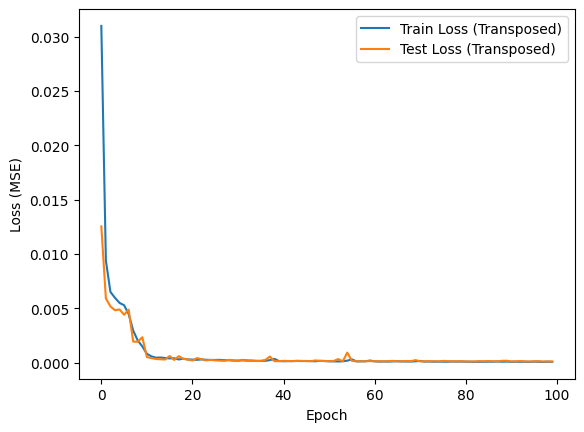

In [14]:
plt.plot(training_info1["train_losses"], label="Train Loss (Transposed)")
plt.plot(training_info1["test_losses"], label="Test Loss (Transposed)")
# plt.plot(training_info_T["train_losses"], label="Train Loss")
# plt.plot(training_info_T["test_losses"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

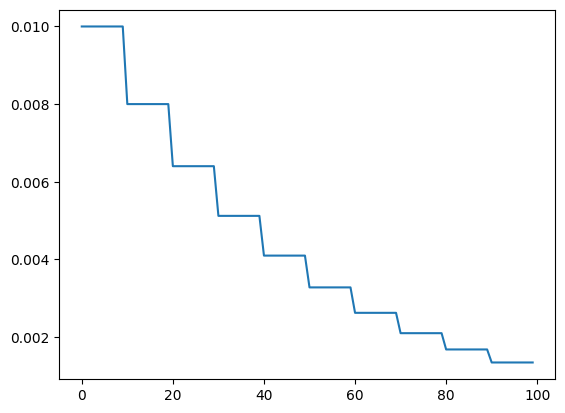

In [15]:

plt.plot(training_info1["lrs"], label="LR")

## Accuracy Computation

In [16]:
from torcheval.metrics import R2Score
from torch.utils.data import DataLoader

def compute_r2_for(dataset):
    r2 = R2Score()
    train_data = DataLoader(dataset, batch_size=256, shuffle=True)
    for _, data in enumerate(train_data):
        inputs, goal = data[0], data[1]
        outputs = model(inputs)
        r2.update(goal, outputs)
    return r2.compute()

model.to("cpu")
model.train()
with torch.no_grad():
    train_r2 = compute_r2_for(train)
    print(f"R^2 for training data: {train_r2}")
    test_r2 = compute_r2_for(test)
    print(f"R^2 for testing data: {test_r2}")

NameError: name 'model' is not defined

In [ ]:
from torcheval.metrics import MeanSquaredError

def compute_mse_for(dataset):
    mse = MeanSquaredError()
    train_data = DataLoader(dataset, batch_size=256, shuffle=True)
    for _, data in enumerate(train_data):
        inputs, goal = data[0], data[1]
        outputs = model(inputs)
        mse.update(outputs, goal)
    return mse.compute()

model.to("cpu")
model.train()
with torch.no_grad():
    train_mse = compute_mse_for(train)
    print(f"MSE for training data: {train_mse}")
    test_mse = compute_mse_for(test)
    print(f"MSE for testing data: {test_mse}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

roads = range(0, 500)

#common sense testing
# call the model ith t increments of 360 for 10 timesteps and print the results
allres = []
for i in roads:
    results = []
    inpt = test[i][0]
    for i in range(0, 50):
        inpt[-2, -1] = 1 * i
        results.append(model(inpt.unsqueeze(0)).squeeze() * rut.iri_range + rut.mean_iri)
        results[-1] = results[-1].detach().numpy()
    allres.append(results)
allres = np.array(allres)
for i in range(50):
    plt.plot(allres[i, :, 0], label=f"Road {i}")